In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
dataset_train = pd.read_csv('forml.csv')  # 讀取
dataset_train.drop(['Unnamed: 0','date','day','month','year','D+1','D+3','D+5','D+7'],axis=1,inplace=True)
training_data = dataset_train[:7038]
test_data = dataset_train[7038:7768]
print(training_data.shape)
print(test_data.columns)
print(training_data.shape[1])

(7038, 19)
Index(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'pressure',
       'temperature', 'humidity', 'windspeed', 'wind_direction',
       'maximum_windspeed_x', 'maximum_wind_direction', 'rainfall', 'volume',
       'level', 'alarms_count', 'price'],
      dtype='object')
19


In [3]:
#sc = MinMaxScaler(feature_range=(0,1))
sc = StandardScaler()
training_data_sc = sc.fit_transform(training_data)
test_data_sc = sc.transform(test_data)
print(training_data_sc[1,18])

-0.8126060181758046


In [4]:
def createXY(dataset, n_past):
    X = []
    y = []
    for i in range(n_past, len(dataset)):
        X.append(dataset[i - n_past:i, 0:dataset.shape[1]-1])
        y.append(dataset[i,18])
    return np.array(X),np.array(y)

In [5]:
train_X, train_y = createXY(training_data_sc, 15)
test_X, test_y = createXY(test_data_sc,15)

In [6]:
%load_ext tensorboard

In [17]:
# Import the Keras libraries and packages
import os, datetime
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
# regressor = Sequential()
model = keras.Sequential()
# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (15,18)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

logdir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 15, 50)            13800     
                                                                 
 dropout (Dropout)           (None, 15, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 15, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 15, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 15, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 15, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [18]:
# Compiling
model.compile(keras.optimizers.Adam(0.0001),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError()])

# 進行訓練
model.fit(train_X, train_y, epochs = 75, batch_size = 128, callbacks=[tensorboard_callback])

Epoch 1/75
55/55 [==============================] - 8s 35ms/step - loss: 0.8310 - mean_absolute_error: 0.7328
Epoch 2/75
55/55 [==============================] - 2s 35ms/step - loss: 0.4752 - mean_absolute_error: 0.5280
Epoch 3/75
55/55 [==============================] - 2s 35ms/step - loss: 0.4153 - mean_absolute_error: 0.4797
Epoch 4/75
55/55 [==============================] - 2s 34ms/step - loss: 0.3950 - mean_absolute_error: 0.4696
Epoch 5/75
55/55 [==============================] - 2s 34ms/step - loss: 0.3889 - mean_absolute_error: 0.4635
Epoch 6/75
55/55 [==============================] - 2s 34ms/step - loss: 0.3800 - mean_absolute_error: 0.4596
Epoch 7/75
55/55 [==============================] - 2s 36ms/step - loss: 0.3710 - mean_absolute_error: 0.4544
Epoch 8/75
55/55 [==============================] - 2s 35ms/step - loss: 0.3653 - mean_absolute_error: 0.4509
Epoch 9/75
55/55 [==============================] - 2s 35ms/step - loss: 0.3602 - mean_absolute_error: 0.4465
Epoch 10/7

In [19]:
%tensorboard --logdir='logs' --host=127.0.0.1

Reusing TensorBoard on port 6006 (pid 20452), started 0:08:30 ago. (Use '!kill 20452' to kill it.)

In [20]:
predicted_price = model.predict(test_X)
predicted_price_array = np.repeat(predicted_price,19,axis=-1)
pred = sc.inverse_transform(np.reshape(predicted_price_array,(len(predicted_price),19)))[:,18]
print(pred)

23/23 [==============================] - 1s 6ms/step
[14.134253  13.417299  12.367803  10.498411   8.357063   7.6038632
  7.375462   7.98231    7.312509   6.9568467  7.465406   7.8502383
  8.233225   9.20676    9.941511   9.871764  10.542061  11.718175
 11.623833  11.951698  12.381338  11.735298  11.15987   10.487468
 10.341608   9.611783   8.365199   7.571979   9.275413  10.54154
 11.015468  10.930702  12.312293  11.633844  11.3777685 11.868926
 12.292428  11.665109  10.081723   9.119338   9.011671   9.897391
  9.692758   9.2892475  8.793858   8.687642   8.746559   8.6639385
  8.901969   8.429349   7.4382186  8.484939   9.516062  11.15337
 12.8926115 14.1802435 14.397     15.1583    17.47294   18.404493
 17.357965  17.264313  15.145516  15.2948265 15.294424  15.559421
 16.551868  17.274496  16.397993  17.351562  18.151443  18.88824
 20.638998  23.040432  24.103958  25.95465   28.526703  30.59033
 32.351284  32.953625  33.104588  32.981083  32.10055   29.987293
 24.117775  21.458422  1

In [21]:
real_price_array = np.repeat(test_y,19,axis=-1)
real = sc.inverse_transform(np.reshape(real_price_array,(len(test_y),19)))[:,18]

In [22]:
print(real)

[ 8.6  8.5  7.8  7.6  7.7  7.8  7.4  8.1  7.5  7.5  7.3  8.6  8.7  8.6
  8.7  8.7  9.4  8.7  9.4  9.4  8.4  7.7  7.7  7.8  7.7  8.5 11.1 13.8
  9.2 10.9 11.9  9.4  9.3  9.6  9.4 11.9 10.7 10.2 10.8 10.9 10.8  9.2
 11.6 12.2 13.7 13.9 12.  11.6 11.1 10.7 11.3 13.9 14.5 10.7 10.6 12.3
 11.6 11.2 11.4 12.4 13.4 14.5 14.7 14.9 14.5 14.8 15.9 14.8 15.6 16.4
 17.8 18.7 16.7 16.2 17.8 18.5 18.7 17.4 16.6 14.8 15.7 15.1 16.2 20.3
 20.2 17.5 18.  24.9 25.3 28.7 26.  28.6 29.7 29.  29.  36.1 38.9 40.
 37.7 32.  31.1 32.9 32.4 24.6 28.2 28.  26.4 23.  24.3 27.1 25.4 24.5
 25.5 22.  21.1 21.  22.2 25.6 24.7 26.6 22.9 25.5 26.2 23.5 23.2 26.7
 23.6 26.7 28.7 33.2 29.9 30.7 27.6 31.6 37.8 35.  31.3 30.4 31.1 32.7
 33.5 31.  35.4 36.9 38.9 41.5 35.8 35.2 30.5 33.9 30.6 39.9 49.4 36.4
 29.7 30.7 31.9 36.2 31.5 35.3 31.7 26.9 24.6 33.5 31.5 30.2 30.4 30.6
 26.8 28.  27.4 37.  30.2 28.  32.3 35.7 31.7 29.5 29.  31.3 33.5 35.
 33.6 27.9 32.9 36.3 40.7 39.6 39.1 37.7 38.1 37.5 43.2 38.2 33.4 29.8
 31.5 36

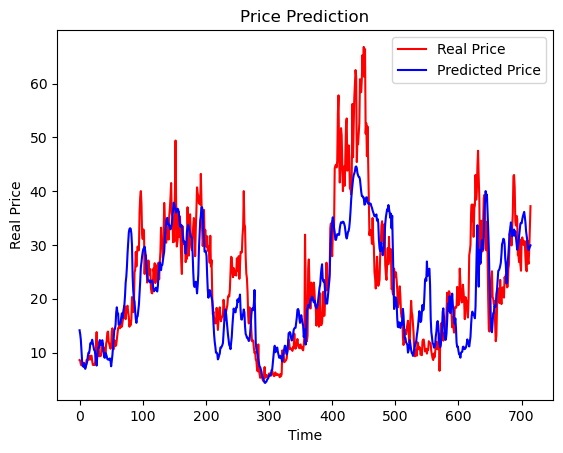

In [23]:
# Visualising the results
plt.plot(real, color = 'red', label = 'Real Price')  # 紅線表示真實股價
plt.plot(pred, color = 'blue', label = 'Predicted Price')  # 藍線表示預測股價
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Real Price')
plt.legend()
plt.show()